# Part 1: Target Market and Financial Opportunity

## Understanding the problem

#### Microsoft Profile

Microsoft is an American multinational technology company. Its business includes the development, manufacturing, licensing, suport and selling of computer software, consumer electornics, personal computers, and related services. 

Microsfot is considered one of the 'Big Five' technology companies alongside Amazon, Apple, Google, and Facebook. Interestingly, two of those (Amazon and Apple) have already been participants in the movie industries through their streaming services (Amazon's Prime Video and Apple TV Plus) and own original production content.

As one of the 'Big Five', Microsoft services markets worldwide, with an estimated 163,000 employees working across 150 locations, USD 143B  revenue (2020) and a market capitalization of USD 1.6T (2020). 

*Source: Wikipedia : https://en.wikipedia.org/wiki/Microsoft*

#### The Problem

As a multinational company, the Microsoft has wide influence all over the world, so the question presents itself -- should the company focus its Movie Studio projects domestically or is there an opportunity overseas? 

# Where should Microsoft target its movie production efforts? 


## 1. Looking at Box Office Returns

The first place to start examining potential markets for Microsoft's movie making business is looking at the domestic v. international box office revenues, since this remains the primary source of revenue in the movie production business. 

The data chosen for this analysis was from the "Box Office Mojo" website (www.boxofficemojo.com). Since we cannot directly compare domestic v. international box office returns, as international includes the sum of multiple countries, we will Web Scrape for local annual box office data for multiple countries. 

We have decide to settle on 20 countries, selected by largest film industries in the world measured by profit. 

#### The list of examined countries is as follows:
*(Alphabetically ordered)*

   Australia (https://www.boxofficemojo.com/year/?area=AU),
   Brazil (https://www.boxofficemojo.com/year/?area=BR), 
   China (https://www.boxofficemojo.com/year/?area=CH), 
   UAE (https://www.boxofficemojo.com/year/?area=AE), 
   France (https://www.boxofficemojo.com/year/?area=FR), 
   Germany (https://www.boxofficemojo.com/year/?area=GE), 
   Hong Kong (https://www.boxofficemojo.com/year/?area=HK), 
   India (https://www.boxofficemojo.com/year/?area=IN), 
   Indonesia (https://www.boxofficemojo.com/year/?area=ID), 
   Italy (https://www.boxofficemojo.com/year/?area=IT), 
   Japan (https://www.boxofficemojo.com/year/?area=JP),
   Malaysia (https://www.boxofficemojo.com/year/?area=MY),
   Mexico (https://www.boxofficemojo.com/year/?area=MX),
   Netherlands (https://www.boxofficemojo.com/year/?area=NL),
   Poland (https://www.boxofficemojo.com/year/?area=PL), 
   South Korea (https://www.boxofficemojo.com/year/?area=KR),
   Spain (https://www.boxofficemojo.com/year/?area=SP),
   Taiwan (https://www.boxofficemojo.com/year/?area=TW),
   United Kingdom (https://www.boxofficemojo.com/year/?area=GB)

#### Importing the required libraries

In [98]:
#libraries for http requests and web scraping
import requests
from bs4 import BeautifulSoup

#pandas and numpy for working with DataFrames
import pandas as pd
import numpy as np

#import regex to clean some data
import re

#matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import Folium for geographic visualization
import folium

## 1.1 Web Scraping Box Office Data

We are interested in web scraping 20 html pages containing the annual gross box office data.
Within each page, we are interested in extracting the following information per country:
- year
- gross revenue in USD
- total number of movies released
- average cost per movie produced
- title of the top released film of the year

Since we will be repeating the process, we will be defining appropriate functions for extracting the information, cleaning it and converting it to a DataFrame.

#### Defining the Web Scraping functions


In [2]:
#This function converts the box office total gross string extracted from the html doc to an integer
def cleanup_str_to_int(string):
    """This function converts the $xxx,xxx currency revenue
    format to an interger"""
    
    string = string.replace('$', '') #removes the '$' sign from the string
    string = string.replace(',', '') #removes the ',' separators from the string
    return int(string) #returns the number as an integer

In [3]:
#This function creates the total gross and average cost per movie lists
#it takes as input the money list containing the data for gross and average
#and poplates the empty gross and average lists with clean integers
def money_lists(money, gross, average):
    """Extracts the content from money list
    to populate Gross and Average cost lists
    Arguments are: (money, gross, average)"""
    
    for i in range(len(money)):
        if i % 2 == 0:
            gross.append(cleanup_str_to_int(money[i]))
        else:
            average.append(cleanup_str_to_int(money[i]))

In [4]:
#This function takes as arguments the container and empty lists for each series we are interested in
#It assembles the data for each empty list, extracting it from the html page
#the function returns the 5 lists with the relevant data
def assemble_data(container, year, gross, average, release, top):
    """Assembles the data extracted from the container argument to each of the 5
    inputed empty lists. 
    Arguments are: (container, year, gross, average, release, top)"""
    
    #year
    tyear = [td.find('a').string for td in container.findAll('td', class_ = "a-text-left mojo-header-column mojo-truncate mojo-field-type-year mojo-sort-column")]
    for y in tyear: 
        year.append(y) #append to the year list
    #total gross and gross average
    money = [td.string for td in container.findAll('td', class_ = "a-text-right mojo-field-type-money")]    
    money_lists(money, gross, average) #use the money lists function defined above
    #number of releases
    trelease = [td.string for td in container.findAll('td', class_ = "a-text-right mojo-field-type-positive_integer")]
    for num in trelease:
        release.append(num) #append to the release list
    #No.1 title of the year
    ttop  = [td.find('a').string for td in container.findAll('td', class_= "a-text-left mojo-field-type-release mojo-cell-wide")]
    for title in ttop:
        top.append(title) #append to the top list
    return year, gross, average, release, top #return the populated lists

In [5]:
#Created BOM DataFrame function
def makedf(year, gross, release, average, top):
    """Creates and returns the DataFrame for the input Series: 
    Year, Gross, Release, Average and Top"""
    
    df = pd.DataFrame([year, gross, release, average, top]).transpose()
    df.columns = ['Year', 'Total Gross', 'Number of Releases', 'Average', '#1 Release Title']
    return df

### Example: Importing Domestic Box Office Data
United States: https://www.boxofficemojo.com/year/?ref_=bo_nb_di_secondarytab

In [6]:
#Start by requesting the html page in question and loading its content for parsing
html_page = requests.get('https://www.boxofficemojo.com/year/?ref_=bo_nb_di_secondarytab')
usa_box = BeautifulSoup(html_page.content, 'html.parser')

#Load a container to inspect the table section of the page we are interested in
usa = usa_box.find(id = "table")

In [7]:
#Define the Series as empty lists
usa_year = []
usa_gross = []
usa_average = []
usa_releases = []
usa_title = []

#Use the functions to assemble the data, create the DataFrame and preview it
assemble_data(usa, usa_year, usa_gross, usa_average, usa_releases, usa_title)
bom_usa = makedf(usa_year, usa_gross, usa_releases, usa_average, usa_title)
bom_usa.head()

,Year,Total Gross,Number of Releases,Average,#1 Release Title
0,2020,1939360806,373,5199358,Bad Boys for Life
1,2019,11320836510,909,12454165,Avengers: Endgame
2,2018,11889341443,993,11973153,Black Panther
3,2017,11072815067,852,12996261,Star Wars: Episode VIII - The Last Jedi
4,2016,11377066920,856,13290966,Finding Dory


In [12]:
#Create a .csv file to store the dataset
bom_usa.to_csv('bom_usa.csv')

## 1.2 Importing Data

For the purpose of convenience in this presentation, we have already converted all 20 of the html pages to .csv files and will be importing them as DataFrames.

Because we will be working with a large number of DataFrames, we will keep track of them in a dictionnary.

In [11]:
import glob

#Store the path + filenames of all the .csv files we will import
all_files = glob.glob('box_office_data/bom*')

#Create an empty dictionary to contain all the country names and their bom dataframes
dflist = {}

#Iterate over all_files list to import all dataframes
#all file names are of format 'box_office_data/bom_country_name.csv'

for filename in all_files:
    dflist[filename[20:-4]] = pd.read_csv(filename)

In [12]:
#Preview keys for list of countries included in the analysis
print(dflist.keys())

#Preview entry for United States
dflist["usa"].head()

dict_keys(['australia', 'brazil', 'china', 'emirates', 'france', 'germany', 'hongkong', 'india', 'indonesia', 'italy', 'japan', 'malaysia', 'mexico', 'netherlands', 'poland', 'southkorea', 'spain', 'taiwan', 'uk', 'usa'])


,Unnamed: 0,Year,Total Gross,Number of Releases,Average,#1 Release Title
0,0,2020,1923713952,361,5328847,Bad Boys for Life
1,1,2019,11320839559,909,12454168,Avengers: Endgame
2,2,2018,11889341443,993,11973153,Black Panther
3,3,2017,11072815067,852,12996261,Star Wars: Episode VIII - The Last Jedi
4,4,2016,11377066920,856,13290966,Finding Dory


## 1.3 Cleaning the Data

In [13]:
#Drop the unnecessary extra index
for value in dflist.values():
    value.drop('Unnamed: 0', axis = 1, inplace = True)

In [14]:
#Transforming the Total Gross values to millions
for df in dflist:
    dflist[df]['Total Gross'] = dflist[df]['Total Gross'].map(lambda x: round(x/1000000))
    dflist[df] = dflist[df].rename(columns = {'Total Gross' : 'Total Gross in Mn'})

In [15]:
#Preview the USA DataFrame
dflist['usa'].head()

,Year,Total Gross in Mn,Number of Releases,Average,#1 Release Title
0,2020,1924,361,5328847,Bad Boys for Life
1,2019,11321,909,12454168,Avengers: Endgame
2,2018,11889,993,11973153,Black Panther
3,2017,11073,852,12996261,Star Wars: Episode VIII - The Last Jedi
4,2016,11377,856,13290966,Finding Dory


Note: Not all countries contain data for the same period of time. The US for example contains significantly older box office data dating back to 1977, while none of the remaining countries included in this study contain an entry prior to 2000. 

Since we will be examining the growth rate of the box office over the past 20 years, which we will take as indicative of the growth in local audiences, the additional data might impact the calculation of domestic growth rate. 

Therefore we will be removing the additional years in domestic DataFrame

In [16]:
#Drop the years prior to 2000 for domestic data
dflist["usa"].drop(dflist["usa"].index[21:], inplace = True)

## 1.4 Visualizing the Data

Our first step is to gage the market size for each country and its growth over time. For that reason, we will be visualizing the growth of each country's total box office over time. 

In [17]:
#Define the style of visualizations
plt.style.use("bmh")

#### Visualizing Market size & growth

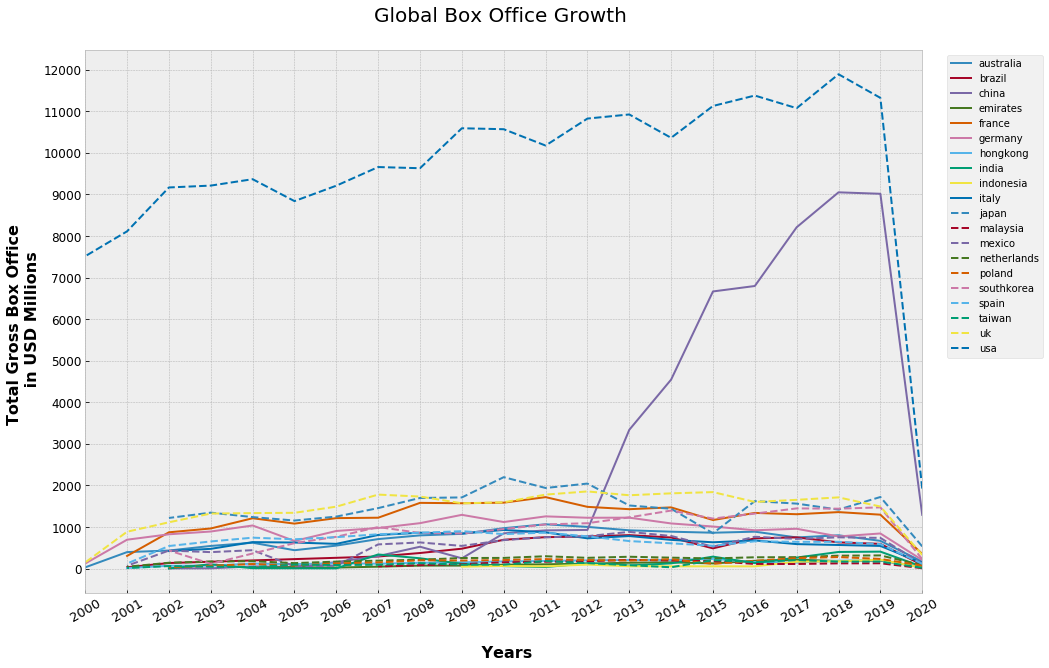

In [18]:
#Define the figure and subplot ax
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(111)

#Load the DataFrames
#Split in half ensure different linestyles to differentiate countries
for df in dflist:
    if df in list(dflist.keys())[:10]:
        ax.plot(dflist[df]['Year'], dflist[df]['Total Gross in Mn'], label = df)
    else:
        ax.plot(dflist[df]['Year'], dflist[df]['Total Gross in Mn'], label = df, linestyle = 'dashed')

#Format the x and y axis
ax.set_xlim(2000, 2020)
xticks = np.linspace(start = 2000, stop = 2020, num = 20)
yticks = list(range(0, 13000, 1000))
plt.xticks(list(range(2000, 2021)), fontsize = 13, rotation = 30)
plt.yticks(yticks, fontsize = 12)

#Format the table
ax.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.xlabel('\n Years', fontsize = 16, fontweight = 'bold')
plt.ylabel('Total Gross Box Office \n in USD Millions', fontsize = 16, fontweight = 'bold')

plt.title('Global Box Office Growth \n', fontsize = 20)

plt.show()

As we can see in the plot above, the market size has consistently remained significantly greater domestically than in other countries, and has continued to grow over the past 20 years. However, more eye-catching is China, whose movie industry has grown at a very rapid pace since 2012.

However, for the remaining countries, we have to look on the smaller scale:

#### Taking a closer look at international box office growth

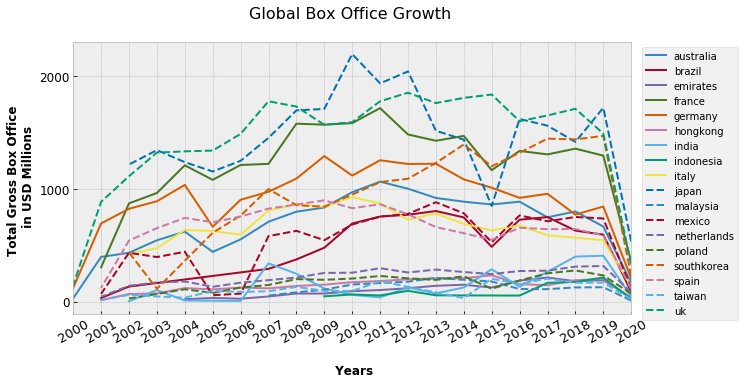

In [19]:
#Define the figure and subplot ax
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(111)

#Load the DataFrames
#Split in half ensure different linestyles to differentiate countries
#Exclude the United States and China
for df in dflist:
    if df != 'usa' and df != 'china':
        if df in list(dflist.keys())[:10]:
            ax.plot(dflist[df]['Year'], dflist[df]['Total Gross in Mn'], label = df)
        else:
            ax.plot(dflist[df]['Year'], dflist[df]['Total Gross in Mn'], label = df, linestyle = 'dashed')

#Format the x and y axis
ax.set_xlim(2000, 2020)
xticks = np.linspace(start = 2000, stop = 2020, num = 20)
yticks = list(range(0, 3000, 1000))
plt.xticks(list(range(2000, 2021)), fontsize = 13, rotation = 30)
plt.yticks(yticks, fontsize = 12)

#Format the table
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1))
plt.xlabel('\n Years', fontsize = 12, fontweight = 'bold')
plt.ylabel('Total Gross Box Office \n in USD Millions', fontsize = 12, fontweight = 'bold')

plt.title('Global Box Office Growth \n', fontsize = 16)

plt.show()

Due to the difference in market sizes between the United States, China and remaining countries in the study, it is difficult to directly compare the growth rate from the visualizations above. Therefore, we will calculate the Compound Annual Growth Rate of each country's box office as an estimate to the growth in audience in order to compare which movie industry is growing the fastest, aside from the obvious that is China. 

For this, we will be ignoring 2020 data, as the fall in returns we see above is attributed to a black swan event and therefore has no bearing on the instrinsic growth of the industry's audiences, and by extension, revenue.

#### Calculating CAGR

In [140]:
#Create an empty dictionnary to hold the CAGR for each country
cagr = {}

#Calculate CAGR:
for df in dflist:
    #find the required values
    start_value = float(dflist[df].iloc[-1, 1]) #Starting year for box office data
    end_value = float(dflist[df].iloc[1, 1]) #2019 Box office
    num_of_years = int(dflist[df].index[-1]) #Index of the last year since we are excluding 2020 
    #calculate CAGR
    growth_rate = ((end_value / start_value)**(1/num_of_years) - 1) * 100 
    #add to dictionary
    cagr[df] = round(growth_rate, 1)

#### Calculating the growth of number of releases

In addition to CAGR, we will add the growth on the number of movies released per year, to examine a possible correlation between both. 

In [159]:
#Create an empty dictionnary to hold the number of release growth for each country
release_gr = {}

#Calculate average growth in number of releases
for df in dflist.keys():
    start_value = dflist[df].iloc[-1, 2] #Number of releases the starting year
    end_value = dflist[df].iloc[1, 2] #Number of releases in 2019
    num_of_years = int(dflist[df].index[-1]) #index of the last year for number of years (excluding 2020)
    #Calculate growth rate
    growth_rate = ((end_value / start_value)**(1/num_of_years) - 1) * 100
    #add to dictionary
    release_gr[df] = round(growth_rate, 1)

#### Creating a Growth DataFrame

In [233]:
#Create the DataFrame
growthdf = pd.DataFrame([cagr, release_gr]).T
growthdf.columns = ['Compound Annual Growth Rate', 'Release Number Growth']

#Sort the DataFrame by CAGR values
growthdf.sort_values(['Compound Annual Growth Rate'], ascending = True, inplace = True)

#Title the name of the countries
growthdf.set_index(growthdf.index.str.title(), inplace = True)

In [234]:
#Preview DataFrame
growthdf.head()

,Compound Annual Growth Rate,Release Number Growth
Italy,1.4,2.8
Japan,1.9,2.3
Usa,2.1,3.7
Malaysia,7.0,-7.7
Southkorea,7.4,7.0


#### Visualizing Market Growth

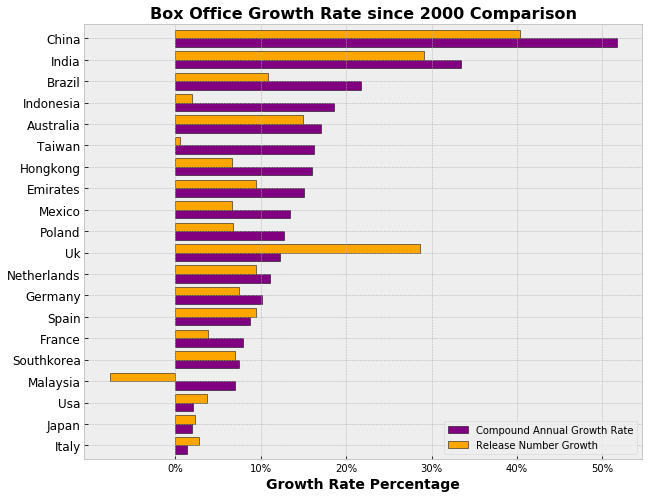

In [251]:
#Set the plot
growthdf.plot(kind = 'barh', figsize = (10, 8), color = ['purple', 'orange'], edgecolor = 'black',  width = .8);

#Format the axis
plt.yticks(fontsize = 12)
xticks = list(range(0, 60, 10))
xticklabels = ['{}%'.format(x) for x in xticks]
plt.xticks(xticks, xticklabels)

#Format the Plot
plt.title('Box Office Growth Rate since 2000 Comparison', fontsize = 16, fontweight ='bold')
plt.xlabel('Growth Rate Percentage', fontsize = 14, fontweight = 'bold')

plt.show()

From analyzing the growth rate, we notice that although the United States has a large market size, the faster growing markets in the movie industry are international, with China, India and Brazil dominating with an average of over 20% year-on-year growth, 

Coincidentally, The top two - China and India - also have the hgihest grwoth in number of annual releases, which suggests a possible correlation. Given more time for analysis, this could be an avenue for Microsoft to lead the growth in the industry within these markets. 

# 2. Competitive Analysis

Over the past 10+ years, the movie industry has experience substantial innovation with the introduction of subscription streaming as the new success model for wide media distribution. 

Since the growth of Netflix, now the world's largest streaming service provider with a reported 193 million subscribers, subscription streaming has grown to be a significant source of revenue in the industry. In particular, with the global COVID-19 health crisis in 2020 which lead to the closing of many theatres, the shift in focus to streaming is expected to be even more important. 

Therefore, as seen in the visualizations above depicting the loss in box office revenue, we chose to explore the competition in the space, should Microsoft choose subscription streaming for the distribution of its movies. 

We sourced the data from Wikipedia's compilation of streaming service providers (https://en.wikipedia.org/wiki/Streaming_service_provider) 

## 2.1 Web Scraping Competitive Data

#### Defining the Web Scraping functions

In [23]:
#This function extracts the content text from a wiki table containing competitive data
def extract_clean_text(container):
    """Input html container to extract, clean and return the 
    text contained on the page"""
    
    #Get the text
    page_text = container.get_text() 
    
    #Cleaning the text
    page_text = page_text.split('\n\n') #Split by rows
    
    #Protect against empty cells by setting clear separation between the rows(i.e.competitor data)
    page_text = '|'.join(page_text) #rejoin to prepare category split
    page_text = page_text.split('\n')
    for i in range(0, len(page_text)):
        page_text[i] = page_text[i].split('|') #Split at the allocated spot
        if '' in page_text[i]: #Remove the empty characters once more
            page_text[i].remove('')
        
    #Return the resulting list
    return page_text

#### Web Scraping Wikipedia

In [24]:
#Make a request to import the Wikipedia HTML page and load for parsing
html_page2 = requests.get('https://en.wikipedia.org/wiki/Streaming_service_provider')
streaming_services = BeautifulSoup(html_page2.content, 'html.parser')

In [25]:
#There are 4 different tables containing competitive data on the page
#which will require multiple containers

#find first container
container = streaming_services.find('table', class_ = "wikitable sortable") 

#create final_text list and populate with the text from Table 1
final_text = extract_clean_text(container)

#Repeat process for remaining 3 tables
for loop in range(3):
    container = container.find_next_sibling('table', class_ = "wikitable sortable")
    extracted_text = extract_clean_text(container) #get the text
    for lst in extracted_text:
        final_text.append(lst)

## 2.2. Cleaning & Exploring the Data

The created list contains a list of each row entry in the table, per competitor. However some of the entries are missing data, the column names list is repeated and there are empty lists included as well. The data needs to be cleaned

In [27]:
#A few of the lists are missing the 'Parent' company entry due to merged cells in the origin html
#This will cause the data to shift a column in the dataframe
#So we will clean these by inserting an empty entry at index 0
shifted_lst_index = [14,16,17]
for i in shifted_lst_index:
    final_text[i].insert(0, '')

In [28]:
#Create a DataFrame to preview the data for cleaning
#skip first entry in the final_text entry as it is the column names
wikidf = pd.DataFrame(final_text[1:], columns = final_text[0])

#View the DataFrame details
wikidf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
Parent          28 non-null object
Service         28 non-null object
Launch          28 non-null object
Subscribers     28 non-null object
Content         28 non-null object
Areas Served    28 non-null object
Ref             28 non-null object
                23 non-null object
dtypes: object(8)
memory usage: 2.1+ KB


In [29]:
#Remove the empty rows
wikidf.dropna(how = 'all', inplace = True)

#Identify and drop repeated rows containing column names
to_remove = wikidf.loc[(wikidf['Parent'] == 'Parent') & (wikidf['Service'] == 'Service')]
wikidf.drop(to_remove.index, inplace = True)

#Reset the index
wikidf.reset_index(inplace = True)

#Drop the unnecessary old index, Ref and empty columns
wikidf.drop(['index', 'Ref', ''], axis = 1, inplace =True)

In [30]:
#Split the 'Areas Served' cell content into lists of countries/data entries
wikidf['Areas Served'] = wikidf['Areas Served'].map(lambda x: x.split(', '))

In [31]:
#Preview the DataFrame
wikidf.head()

,Parent,Service,Launch,Subscribers,Content,Areas Served
0,"Netflix, Inc.",Netflix,"January 16, 2007[a]",193 million,"Netflix Originals, Studio Ghibli,[b] licensed ...",[Worldwide[c]]
1,Amazon,Prime Video,"September 7, 2006",150 million,"Amazon Studios, Discovery, ITV, licensed conte...",[Worldwide[d]]
2,The Walt Disney Company,Disney+,"November 12, 2019",60.5 million,"Disney, Marvel, Lucasfilm, Pixar, National Geo...","[Australia, Austria, Belgium, Canada, Channel ..."
3,The Walt Disney Company,Hulu,"October 29, 2007",35.5 million,"ABC Signature, 20th Television, FX Networks, F...","[United States, Japan]"
4,Google,YouTube Premium,"October 31, 2015",20 million,YouTube Originals,[95 countries]


In [32]:
#Delete the '[..]' entries and empty entries
for lst in wikidf['Areas Served']:
    for i in range(len(lst)):
        lst[i] = re.sub("[[].*?[]]", '', lst[i])

In [33]:
#Make a list of all areas served in the DataFrame
countries = []
for lst in wikidf['Areas Served']:
    [countries.append(item) for item in lst if item != '' and item not in countries]

In [34]:
#Create a reference dictionary to compare areas served
areas_count = {}
for country in countries:
    if 'countries' in country:#Assume the entries from multiple countries operate Worldwide
        areas_count['Worldwide'] = [] 
    else:
        areas_count[country] = [] #Create a sequence of empty list values for each area

In [36]:
#Match service providers to area served in dictionary
for i in range(len(wikidf)):
        for area in wikidf['Areas Served'][i]:
            if area in list(areas_count.keys()):
                lst = areas_count[area]
                lst.append(wikidf['Service'][i])

For the purpose of this analysis, we assume that service providers in the 'Worldwide' category would appear in every area included

In [37]:
#Add worldwide service providers to each area
for service in areas_count['Worldwide']:
    [areas_count[key].append(service) for key in areas_count.keys() 
    if key != 'Worldwide' and service not in areas_count[key]]
    
#Drop Worldwide category
areas_count.pop('Worldwide')

['Netflix', 'Prime Video', 'Crunchyroll']

Due to the varying nature of the entries scraped from Wikipedia's 'Area Serviced' text, we will be breaking down the areas into regions serviced, to get the best representation of coverage.

#### Breaking down the areas into regions of operation

In [83]:
print(countries)

['Worldwide', 'Australia', 'Austria', 'Belgium', 'Canada', 'Channel Islands', 'Denmark', 'Finland', 'France', 'Germany', 'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Japan', 'Luxembourg', 'Mauritius', 'Monaco', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Puerto Rico', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States', '95 countries', 'Philippines', 'India', 'Indonesia', 'Africa', 'Europe', 'North America', '100 countries', 'Southeast Asia', 'Pakistan', 'Sri Lanka', 'Maldives', 'Nepal', 'Bangladesh', 'Hispanic Latin America', 'Brazil', 'Asia']


In [84]:
#Define reference regions based on the existing entries
north_america = ['North America', 'United States', 'Canada']
latam = ['Latin America', 'Mexico', 'Brazil', 'Puerto Rico', 'Hispanic Latin America']
asia = ['Asia', 'Southeast Asia', 'China', 'India', 'Hong Kong',  'South Korea', 'Philippines', 'Pakistan', 'Sri Lanka', 'Nepal'
       'Bangladesh', 'Maldives', 'Indonesia']
europe = ['Europe', 'France', 'United Kingdom', 'Italy', 'Spain', 'Austria', 'Belgium', 'Channel Islands', 'Finland', 'Iceland',
          'Ireland', 'Isle of Man', 'Luxembourg', 'Monaco', 'Norway', 'Portugal', 'Sweden', 'Switzerland', 'Denmark', 'Germany', 
          'Netherlands']
africa = ['Africa', 'Mauritius']
australia = ['Australia', 'New Zealand']

#Create a safety list for the unclassified
others = []

In [85]:
#Define a regions dictionary for final geographic classification
regions = {'North America': [], 'Latin America': [], 'Asia': [], 'Europe': [], 'Africa' : [], 'Australia' : []}

In [86]:
#Populate regions with service provider data
for area in areas_count.keys():
    if area in north_america:
        [regions['North America'].append(service) for service in areas_count[area] 
         if service not in regions['North America']]
    elif area in latam:
        [regions['Latin America'].append(service) for service in areas_count[area]
        if service not in regions['Latin America']]
    elif area in asia:
        [regions['Asia'].append(service) for service in areas_count[area]
        if service not in regions['Asia']]
    elif area in europe:
        [regions['Europe'].append(service) for service in areas_count[area]
        if service not in regions['Europe']]
    elif area in africa:
        [regions['Africa'].append(service) for service in areas_count[area]
        if service not in regions['Africa']]
    elif area in australia:
        [regions['Australia'].append(service) for service in areas_count[area]
        if service not in regions['Australia']]
    else:
        others.append(area)

In [87]:
competition = [len(region) for region in regions.values()]
competition

[13, 6, 8, 8, 5, 6]

## 2.3 Visualizing the Data

#### VIsualizing the competition by region

In [97]:
#Create the DataFrame for the map creation
#include the latitudes and longitudes of the regions
map_data = pd.DataFrame({'countries': list(regions.keys()),
                         'lat': [37.09, -14.24, 35.86, 51.16, 4.36, -33.86], 
                         'lon': [-95.71, -51.92, 104.2, 10.45, 18.55, 151.20], 
                        'competition' : competition})

In [94]:
#Create an empty map
base_map = folium.Map(location = [30, 0], zoom_start = 1.5)
base_map

#Adding markers on the map
for i in range(0, len(map_data)):
    folium.Circle(
    location = [map_data.iloc[i]['lat'], map_data.iloc[i]['lon']],
    popup = map_data.iloc[i]['countries'],
    radius = int(map_data.iloc[i]['competition'])*100000,
    color = 'crimson',
    fill = True, 
    fill_color = 'crimson').add_to(base_map)

In [95]:
#Add a title to the map
title_html = '''
<h3 align = "center" style ="font-size:20px"><b>Microsoft Streaming Service Competition Globally </b></h3>
'''

base_map.get_root().html.add_child(folium.Element(title_html))

In [99]:
#Visualize Mcirosoft's competition
base_map

As we can see on the map above, the global distribution of streaming service providers suggests that the United States is the most 'saturated' market in terms of subscription streaming media distribution. Microsoft would have a hard time challenging the existing dominant players in the industry, in particularly if we consider the following facts:

(1) The average person is unlikely to have many streaming subscritpions

(2) Many of the streaming service providers already operating in the US have large libraries of existing content to lure customers (e.g. Netflix lost the license for the popular 'Friends' show, which is now available on HBO's own streaming service) 

(3) It would be a hard sell to acquire licensing on not-Microsoft original content to include on their platform, considering Microsoft has no user base in this industry or existing library which would make it a positive value proposition for movie studios

##### A Note on Data Limitations
Unfortunately, as previously mentioned, we are constricted by the variability of the entries in the Wikipedia scrapped data. Given more time, breaking down competition by country as opposed to region, coupled with market growth data, would yield better insight into the film industry markets with the greatest opportunity for Microsoft to have an impact. 

For instance, some service providers may be present in a single country within a region (e.g. the many providers in Europe), but thus affects the region data as a whole in the analysis above.

# Conclusion

While the United States presents currently the largest market in the movie industry (by box office numbers), the growth of foreign markets in the movie industry present a much more attractive opportunity for Microsoft to distinguish itself amongst its competitors while ensuring revenue growth. 

In addition, with the fall of theatre box office revenue in 2020 due to the onset of COVID-19, the importance of the subscription streaming model for media distribution, has significantly increased. In this case also, the United States does not seem the most attractive opportunity for Microsoft to consider the distribution of its original content, as the competition is higher than in other regions.  

Instead, we would recommend Microsoft to leverage its global influence to brand itself as a supporter of international films by targeting foreign movie markets in order to capture rapidly growing audiences and revenues.

# Future Work

Due to time and data availability constriction, we could not at this time explore the total growth in the global subscription audience, which would have been a very interesting aspect to investigate. 

With the large numbers of streaming service providers available in the United States, is the market share of the big players like Netflix continuing to grow or wavering? 

It would also have been interesting to explore the possible factors underlying the growth in local audiences, to identify potential catalysts, as well as the money spent on production in diffenrent countries to be able to gage ROI